In [7]:
# Import dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve, classification_report
from sklearn.preprocessing import LabelEncoder
import itertools

import os, fnmatch
import librosa
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

# Prepare dataset

In [8]:
SAMPLE_RATE = 16000

MAX_SOUND_CLIP_DURATION=12 # seconds

def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


# get audio data with a fix padding may also chop off some file
def load_file_data (folder, file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [9]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [10]:
# load dataset-a, keep them separate for testing purpose

INPUT_DIR = "data"
A_folder=INPUT_DIR+'/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

load file  data/set_a/artifact__201012172012.wav
fixing audio lenght : artifact__201012172012.wav
load file  data/set_a/artifact__201105040918.wav
fixing audio lenght : artifact__201105040918.wav
load file  data/set_a/artifact__201105041959.wav
fixing audio lenght : artifact__201105041959.wav
load file  data/set_a/artifact__201105051017.wav
fixing audio lenght : artifact__201105051017.wav
load file  data/set_a/artifact__201105060108.wav
fixing audio lenght : artifact__201105060108.wav
load file  data/set_a/artifact__201105061143.wav
fixing audio lenght : artifact__201105061143.wav
load file  data/set_a/artifact__201105190800.wav
fixing audio lenght : artifact__201105190800.wav
load file  data/set_a/artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load file  data/set_a/artifact__201106010559.wav
fixing audio lenght : artifact__201106010559.wav
load file  data/set_a/artifact__201106010602.wav
fixing audio lenght : artifact__201106010602.wav
load file  data/set_

fixing audio lenght : extrahls__201103200218.wav
load file  data/set_a/extrahls__201104021355.wav
fixing audio lenght : extrahls__201104021355.wav
load file  data/set_a/extrahls__201104140118.wav
fixing audio lenght : extrahls__201104140118.wav
load file  data/set_a/extrahls__201104270458.wav
fixing audio lenght : extrahls__201104270458.wav
load file  data/set_a/extrahls__201104270459.wav
fixing audio lenght : extrahls__201104270459.wav
load file  data/set_a/murmur__201101051104.wav
fixing audio lenght : murmur__201101051104.wav
load file  data/set_a/murmur__201101051108.wav
fixing audio lenght : murmur__201101051108.wav
load file  data/set_a/murmur__201101051114.wav
fixing audio lenght : murmur__201101051114.wav
load file  data/set_a/murmur__201101180902.wav
fixing audio lenght : murmur__201101180902.wav
load file  data/set_a/murmur__201102051443.wav
fixing audio lenght : murmur__201102051443.wav
load file  data/set_a/murmur__201102052338.wav
fixing audio lenght : murmur__201102052338

fixing audio lenght : Aunlabelledtest__201108011116.wav
load file  data/set_a/Aunlabelledtest__201108011117.wav
fixing audio lenght : Aunlabelledtest__201108011117.wav
load file  data/set_a/Aunlabelledtest__201108222222.wav
fixing audio lenght : Aunlabelledtest__201108222222.wav
load file  data/set_a/Aunlabelledtest__201108222225.wav
fixing audio lenght : Aunlabelledtest__201108222225.wav
load file  data/set_a/Aunlabelledtest__201108222228.wav
fixing audio lenght : Aunlabelledtest__201108222228.wav
load file  data/set_a/Aunlabelledtest__201108222234.wav
fixing audio lenght : Aunlabelledtest__201108222234.wav
load file  data/set_a/Aunlabelledtest__201108222241.wav
fixing audio lenght : Aunlabelledtest__201108222241.wav
load file  data/set_a/Aunlabelledtest__201108222244.wav
fixing audio lenght : Aunlabelledtest__201108222244.wav
load file  data/set_a/Aunlabelledtest__201108222247.wav
fixing audio lenght : Aunlabelledtest__201108222247.wav
load file  data/set_a/Aunlabelledtest__201108222

In [11]:
# load dataset-b, keep them separate for testing purpose 
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]

load file  data/set_b/normal_noisynormal_101_1305030823364_B.wav
fixing audio lenght : normal_noisynormal_101_1305030823364_B.wav
load file  data/set_b/normal_noisynormal_101_1305030823364_E.wav
fixing audio lenght : normal_noisynormal_101_1305030823364_E.wav
load file  data/set_b/normal_noisynormal_104_1305032492469_A.wav
fixing audio lenght : normal_noisynormal_104_1305032492469_A.wav
load file  data/set_b/normal_noisynormal_105_1305033453095_A.wav
fixing audio lenght : normal_noisynormal_105_1305033453095_A.wav
load file  data/set_b/normal_noisynormal_105_1305033453095_C.wav
fixing audio lenght : normal_noisynormal_105_1305033453095_C.wav
load file  data/set_b/normal_noisynormal_106_1306776721273_A.wav
fixing audio lenght : normal_noisynormal_106_1306776721273_A.wav
load file  data/set_b/normal_noisynormal_107_1305654946865_A.wav
fixing audio lenght : normal_noisynormal_107_1305654946865_A.wav
load file  data/set_b/normal_noisynormal_108_1305654420093_A.wav
fixing audio lenght : nor

load file  data/set_b/normal_noisynormal_149_1306776016110_A.wav
load file  data/set_b/normal_noisynormal_150_1306776340746_A.wav
fixing audio lenght : normal_noisynormal_150_1306776340746_A.wav
load file  data/set_b/normal_noisynormal_151_1306779785624_C.wav
load file  data/set_b/normal_noisynormal_154_1306935608852_C.wav
fixing audio lenght : normal_noisynormal_154_1306935608852_C.wav
load file  data/set_b/normal_noisynormal_155_1306935902813_A.wav
load file  data/set_b/normal_noisynormal_155_1306935902813_C.wav
fixing audio lenght : normal_noisynormal_155_1306935902813_C.wav
load file  data/set_b/normal_noisynormal_157_1306937583792_A.wav
fixing audio lenght : normal_noisynormal_157_1306937583792_A.wav
load file  data/set_b/normal_noisynormal_157_1306937583792_B.wav
load file  data/set_b/normal_noisynormal_158_1306947254705_B1.wav
fixing audio lenght : normal_noisynormal_158_1306947254705_B1.wav
load file  data/set_b/normal_noisynormal_158_1306947254705_D.wav
load file  data/set_b/n

fixing audio lenght : normal__137_1306764999211_C.wav
load file  data/set_b/normal__137_1306764999211_D.wav
fixing audio lenght : normal__137_1306764999211_D.wav
load file  data/set_b/normal__139_1306519274653_A.wav
fixing audio lenght : normal__139_1306519274653_A.wav
load file  data/set_b/normal__140_1306519735121_A.wav
fixing audio lenght : normal__140_1306519735121_A.wav
load file  data/set_b/normal__140_1306519735121_B.wav
fixing audio lenght : normal__140_1306519735121_B.wav
load file  data/set_b/normal__140_1306519735121_D1.wav
fixing audio lenght : normal__140_1306519735121_D1.wav
load file  data/set_b/normal__141_1306520154450_B.wav
fixing audio lenght : normal__141_1306520154450_B.wav
load file  data/set_b/normal__141_1306520154450_C.wav
fixing audio lenght : normal__141_1306520154450_C.wav
load file  data/set_b/normal__143_1306763822290_B.wav
fixing audio lenght : normal__143_1306763822290_B.wav
load file  data/set_b/normal__143_1306763822290_C.wav
fixing audio lenght : norm

load file  data/set_b/normal__184_1308073010307_D.wav
load file  data/set_b/normal__186_1308073648738_C1.wav
fixing audio lenght : normal__186_1308073648738_C1.wav
load file  data/set_b/normal__186_1308073648738_D.wav
fixing audio lenght : normal__186_1308073648738_D.wav
load file  data/set_b/normal__188_1308074301731_C.wav
fixing audio lenght : normal__188_1308074301731_C.wav
load file  data/set_b/normal__188_1308074301731_D.wav
fixing audio lenght : normal__188_1308074301731_D.wav
load file  data/set_b/normal__190_1308076920011_C1.wav
fixing audio lenght : normal__190_1308076920011_C1.wav
load file  data/set_b/normal__190_1308076920011_D.wav
fixing audio lenght : normal__190_1308076920011_D.wav
load file  data/set_b/normal__191_1308077299430_B.wav
load file  data/set_b/normal__194_1308139824187_A.wav
fixing audio lenght : normal__194_1308139824187_A.wav
load file  data/set_b/normal__194_1308139824187_A1.wav
fixing audio lenght : normal__194_1308139824187_A1.wav
load file  data/set_b/

fixing audio lenght : normal__294_1311681084248_D1.wav
load file  data/set_b/normal__295_1311682673157_D.wav
fixing audio lenght : normal__295_1311682673157_D.wav
load file  data/set_b/normal__296_1311682952647_A1.wav
fixing audio lenght : normal__296_1311682952647_A1.wav
load file  data/set_b/normal__296_1311682952647_A2.wav
fixing audio lenght : normal__296_1311682952647_A2.wav
load file  data/set_b/normal__298_1311685888900_B.wav
fixing audio lenght : normal__298_1311685888900_B.wav
load file  data/set_b/normal__299_1311770522820_C.wav
fixing audio lenght : normal__299_1311770522820_C.wav
load file  data/set_b/normal__300_1311772096120_C1.wav
fixing audio lenght : normal__300_1311772096120_C1.wav
load file  data/set_b/murmur_noisymurmur_135_1306428972976_A.wav
fixing audio lenght : murmur_noisymurmur_135_1306428972976_A.wav
load file  data/set_b/murmur_noisymurmur_135_1306428972976_B.wav
fixing audio lenght : murmur_noisymurmur_135_1306428972976_B.wav
load file  data/set_b/murmur_no

load file  data/set_b/murmur__248_1309201683806_A.wav
fixing audio lenght : murmur__248_1309201683806_A.wav
load file  data/set_b/murmur__248_1309201683806_C.wav
fixing audio lenght : murmur__248_1309201683806_C.wav
load file  data/set_b/murmur__254_1309350589009_A.wav
fixing audio lenght : murmur__254_1309350589009_A.wav
load file  data/set_b/murmur__254_1309350589009_A1.wav
fixing audio lenght : murmur__254_1309350589009_A1.wav
load file  data/set_b/murmur__254_1309350589009_C.wav
fixing audio lenght : murmur__254_1309350589009_C.wav
load file  data/set_b/murmur__254_1309350589009_D.wav
fixing audio lenght : murmur__254_1309350589009_D.wav
load file  data/set_b/murmur__276_1311162716489_C.wav
fixing audio lenght : murmur__276_1311162716489_C.wav
load file  data/set_b/murmur__281_1311165683454_A.wav
fixing audio lenght : murmur__281_1311165683454_A.wav
load file  data/set_b/murmur__281_1311165683454_B.wav
fixing audio lenght : murmur__281_1311165683454_B.wav
load file  data/set_b/murm

fixing audio lenght : Bunlabelledtest__109_1305653972028_D.wav
load file  data/set_b/Bunlabelledtest__110_1305655332337_D.wav
fixing audio lenght : Bunlabelledtest__110_1305655332337_D.wav
load file  data/set_b/Bunlabelledtest__112_1306243000964_C.wav
fixing audio lenght : Bunlabelledtest__112_1306243000964_C.wav
load file  data/set_b/Bunlabelledtest__113_1306244002866_C.wav
fixing audio lenght : Bunlabelledtest__113_1306244002866_C.wav
load file  data/set_b/Bunlabelledtest__115_1306259437619_D.wav
fixing audio lenght : Bunlabelledtest__115_1306259437619_D.wav
load file  data/set_b/Bunlabelledtest__116_1306258689913_B.wav
load file  data/set_b/Bunlabelledtest__117_1306262456650_B1.wav
fixing audio lenght : Bunlabelledtest__117_1306262456650_B1.wav
load file  data/set_b/Bunlabelledtest__118_1306262335509_A.wav
fixing audio lenght : Bunlabelledtest__118_1306262335509_A.wav
load file  data/set_b/Bunlabelledtest__118_1306262335509_A1.wav
fixing audio lenght : Bunlabelledtest__118_130626233

fixing audio lenght : Bunlabelledtest__163_1307104470471_B.wav
load file  data/set_b/Bunlabelledtest__163_1307104470471_B1.wav
fixing audio lenght : Bunlabelledtest__163_1307104470471_B1.wav
load file  data/set_b/Bunlabelledtest__163_1307104470471_D.wav
fixing audio lenght : Bunlabelledtest__163_1307104470471_D.wav
load file  data/set_b/Bunlabelledtest__164_1307106095995_D.wav
load file  data/set_b/Bunlabelledtest__165_1307109069581_B.wav
fixing audio lenght : Bunlabelledtest__165_1307109069581_B.wav
load file  data/set_b/Bunlabelledtest__167_1307111318050_C1.wav
fixing audio lenght : Bunlabelledtest__167_1307111318050_C1.wav
load file  data/set_b/Bunlabelledtest__167_1307111318050_D.wav
fixing audio lenght : Bunlabelledtest__167_1307111318050_D.wav
load file  data/set_b/Bunlabelledtest__169_1307970398039_B.wav
load file  data/set_b/Bunlabelledtest__169_1307970398039_C1.wav
fixing audio lenght : Bunlabelledtest__169_1307970398039_C1.wav
load file  data/set_b/Bunlabelledtest__170_130797

load file  data/set_b/Bunlabelledtest__243_1309197760898_D.wav
load file  data/set_b/Bunlabelledtest__245_1309198844065_A.wav
fixing audio lenght : Bunlabelledtest__245_1309198844065_A.wav
load file  data/set_b/Bunlabelledtest__245_1309200438094_C.wav
fixing audio lenght : Bunlabelledtest__245_1309200438094_C.wav
load file  data/set_b/Bunlabelledtest__248_1309201683806_B.wav
fixing audio lenght : Bunlabelledtest__248_1309201683806_B.wav
load file  data/set_b/Bunlabelledtest__248_1309201683806_D.wav
load file  data/set_b/Bunlabelledtest__254_1309350589009_B.wav
fixing audio lenght : Bunlabelledtest__254_1309350589009_B.wav
load file  data/set_b/Bunlabelledtest__255_1309351210897_B.wav
fixing audio lenght : Bunlabelledtest__255_1309351210897_B.wav
load file  data/set_b/Bunlabelledtest__259_1309352630271_B.wav
fixing audio lenght : Bunlabelledtest__259_1309352630271_B.wav
load file  data/set_b/Bunlabelledtest__260_1309353164458_A.wav
fixing audio lenght : Bunlabelledtest__260_130935316445

In [30]:
# Concatenate train and test data
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("Training data records: ",len(x_data))
print ("Testing data records: ",len(test_x))
print("Total records: ", len(x_data) + len(test_x))

Training data records:  585
Testing data records:  247
Total records:  832


In [15]:
# train_test_split train data
X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

In [16]:
# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y = np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

In [17]:
print('info of the dataset')
print()

print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ()

print ("audio data shape: ", X_train.shape)
print ("data size of the array: : %s" % X_train.size)
print ("length of one array element in bytes: ", X_train.itemsize)
print ("total bytes consumed by the elements of the array: ", X_train.nbytes)

print ()
print ("training data shape: ", X_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", X_val.shape)
print ("validation label shape: ", y_val.shape)
print ()
print ("test data shape: ", test_x.shape)
print ("test label shape: ", test_y.shape)

info of the dataset

label shape:  (585,)
data size of the array: : 585
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  2340
0

audio data shape:  (468, 40, 1)
data size of the array: : 18720
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  74880

training data shape:  (468, 40, 1)
training label shape:  (468, 3)

validation data shape:  (117, 40, 1)
validation label shape:  (117, 3)

test data shape:  (247, 40, 1)
test label shape:  (247, 3)


# Model

In [18]:
epochs=100
batch_size=20 
hidden_size=64

model = Sequential()
model.add(LSTM(hidden_size, return_sequences=True, input_shape = (40,1)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc','mse', 'mae'])
model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
weights = ModelCheckpoint(filepath='models/LSTMbeatclassification.h5')
    
history=model.fit(X_train, y_train, 
                  batch_size=batch_size, 
                  epochs=epochs,
                  verbose=0,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping, weights]) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________
Epoch 00017: early stopping


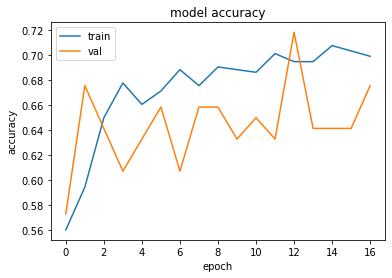

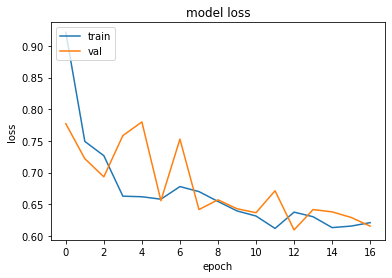

In [19]:
def plot_history(history):
    
    #model accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    #model loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history)

In [20]:
scores = model.evaluate(X_val, y_val, verbose=0)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

Model evaluation accuracy:  68 %


In [21]:
preds = model.predict(X_val) # label scores 
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_val, axis=1) # true classes
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=CLASSES))

              precision    recall  f1-score   support

    artifact       0.89      1.00      0.94         8
      murmur       0.73      0.19      0.30        43
      normal       0.65      0.95      0.77        66

    accuracy                           0.68       117
   macro avg       0.76      0.71      0.67       117
weighted avg       0.69      0.68      0.61       117



In [22]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[ 8  0  0]
 [ 1  8 34]
 [ 0  3 63]]


# ROC plot

In [23]:
n_classes = len(CLASSES)

In [24]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

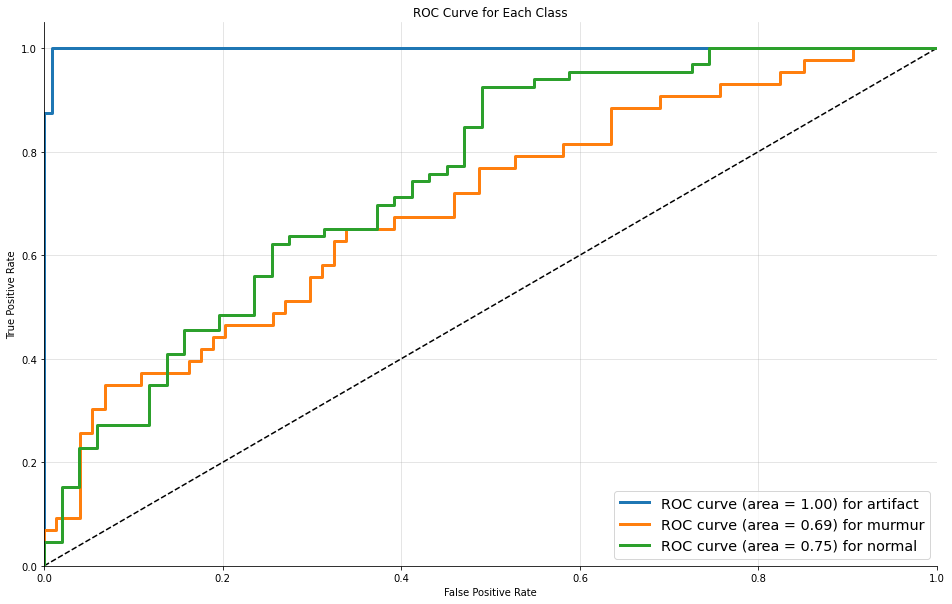

In [25]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], CLASSES[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

# Run model on test data

In [26]:
# Example predict on test data
y_pred = model.predict_classes(test_x, batch_size=32)
print ("prediction test return :",y_pred[1], "-", int_to_label[y_pred[1]])
print()
print('All predicted labels: ' , y_pred)


prediction test return : 2 - normal

All predicted labels:  [0 2 2 1 2 1 1 2 2 2 1 0 2 2 2 1 0 1 1 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


# Try model audio in folder

In [27]:
folder_from = "data"
test_folder=INPUT_DIR+'/test/'
# test data
test_files = fnmatch.filter(os.listdir(INPUT_DIR+'/test'), '*.wav')
test_sounds = load_file_data(folder=test_folder,file_names=test_files, duration=MAX_SOUND_CLIP_DURATION)
print('Testing record files: ', len(test_sounds))

load file  data/test/Bunlabelledtest__103_1305031931979_A.wav
fixing audio lenght : Bunlabelledtest__103_1305031931979_A.wav
load file  data/test/Bunlabelledtest__105_1305033453095_D.wav
Testing record files:  2


In [28]:
test = np.array(test_sounds).reshape((len(test_sounds),-1,1))
#test.shape

In [29]:
# Example predict on test data
y_pred = model.predict_classes(test)
for pred in y_pred:    
    print ("prediction test return :",pred, "-", int_to_label[pred])

prediction test return : 2 - normal
prediction test return : 2 - normal
